In [1]:
# # SETUP ENVIRONMENT
import os
import sys

# # Set Java (SỬA PATH NÀY!)
os.environ['JAVA_HOME'] = 'C:\\Java\\jdk-1.8'

# # QUAN TRỌNG: Bypass Hadoop requirement
os.environ['HADOOP_HOME'] = os.environ.get('JAVA_HOME')
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}\\bin;{os.environ.get('PATH', '')}"

print(f"JAVA_HOME: {os.environ['JAVA_HOME']}")

JAVA_HOME: C:\Java\jdk-1.8


In [2]:
# INSTALL PACKAGES
!pip install pyspark findspark matplotlib seaborn -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# IMPORT LIBRARIES
import findspark
findspark.init()

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('default')
sns.set_palette("husl")


In [4]:
# INITIALIZE SPARK SESSION
import tempfile

spark = SparkSession.builder \
    .appName("YouTubeCategoryAnalysis") \
    .master("local[1]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.warehouse.dir", tempfile.gettempdir()) \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version} started")

Spark 3.2.1 started


In [5]:
# LOAD PREPROCESSED DATA
df = spark.read.csv("./data/preprocessed_data.csv", header=True, inferSchema=True)

print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")
print("\nSAMPLE DATA")
df.show(5)

Loaded 264,767 rows with 13 columns

SAMPLE DATA
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|         description|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:00|brawadis|prank|ba...|   1514614|156908|    5855|        35313|SUBSCRIBE to BRAW...|
|M9Pmf9AB4Mo|Apex Legends | St...|2020-08-11 17:00:10|UC0ZV6M2THA81QT9h...| Apex Legends|        20|2020-08-12 00:00:00|Apex Legends|Ap

In [6]:
# CATEGORY OVERVIEW & MAPPING

# Tạo mapping categoryId sang tên category
df = df.withColumn("category_name", 
    when(col("categoryId") == "1", "Film & Animation")
    .when(col("categoryId") == "2", "Autos & Vehicles")
    .when(col("categoryId") == "10", "Music")
    .when(col("categoryId") == "15", "Pets & Animals")
    .when(col("categoryId") == "17", "Sports")
    .when(col("categoryId") == "19", "Travel & Events")
    .when(col("categoryId") == "20", "Gaming")
    .when(col("categoryId") == "22", "People & Blogs")
    .when(col("categoryId") == "23", "Comedy")
    .when(col("categoryId") == "24", "Entertainment")
    .when(col("categoryId") == "25", "News & Politics")
    .when(col("categoryId") == "26", "Howto & Style")
    .when(col("categoryId") == "27", "Education")
    .when(col("categoryId") == "28", "Science & Technology")
    .otherwise("Unknown")
)

print("=== CATEGORIES IN DATASET ===")
df.select("categoryId", "category_name").distinct().orderBy("categoryId").show()

total_categories = df.select("categoryId").distinct().count()
print(f"\nTotal categories: {total_categories}")

=== CATEGORIES IN DATASET ===
+----------+--------------------+
|categoryId|       category_name|
+----------+--------------------+
|         1|    Film & Animation|
|         2|    Autos & Vehicles|
|        10|               Music|
|        15|      Pets & Animals|
|        17|              Sports|
|        19|     Travel & Events|
|        20|              Gaming|
|        22|      People & Blogs|
|        23|              Comedy|
|        24|       Entertainment|
|        25|     News & Politics|
|        26|       Howto & Style|
|        27|           Education|
|        28|Science & Technology|
|        29|             Unknown|
+----------+--------------------+


Total categories: 15


TOP CATEGORIES BY VIDEO COUNT
+----------+--------------------+-----+
|categoryId|       category_name|count|
+----------+--------------------+-----+
|        24|       Entertainment|53096|
|        20|              Gaming|52251|
|        10|               Music|42786|
|        17|              Sports|30854|
|        22|      People & Blogs|22392|
|        23|              Comedy|12994|
|         1|    Film & Animation|10763|
|        25|     News & Politics| 9600|
|        28|Science & Technology| 8022|
|        26|       Howto & Style| 6995|
|        27|           Education| 6578|
|         2|    Autos & Vehicles| 5420|
|        19|     Travel & Events| 1691|
|        15|      Pets & Animals| 1210|
|        29|             Unknown|  115|
+----------+--------------------+-----+



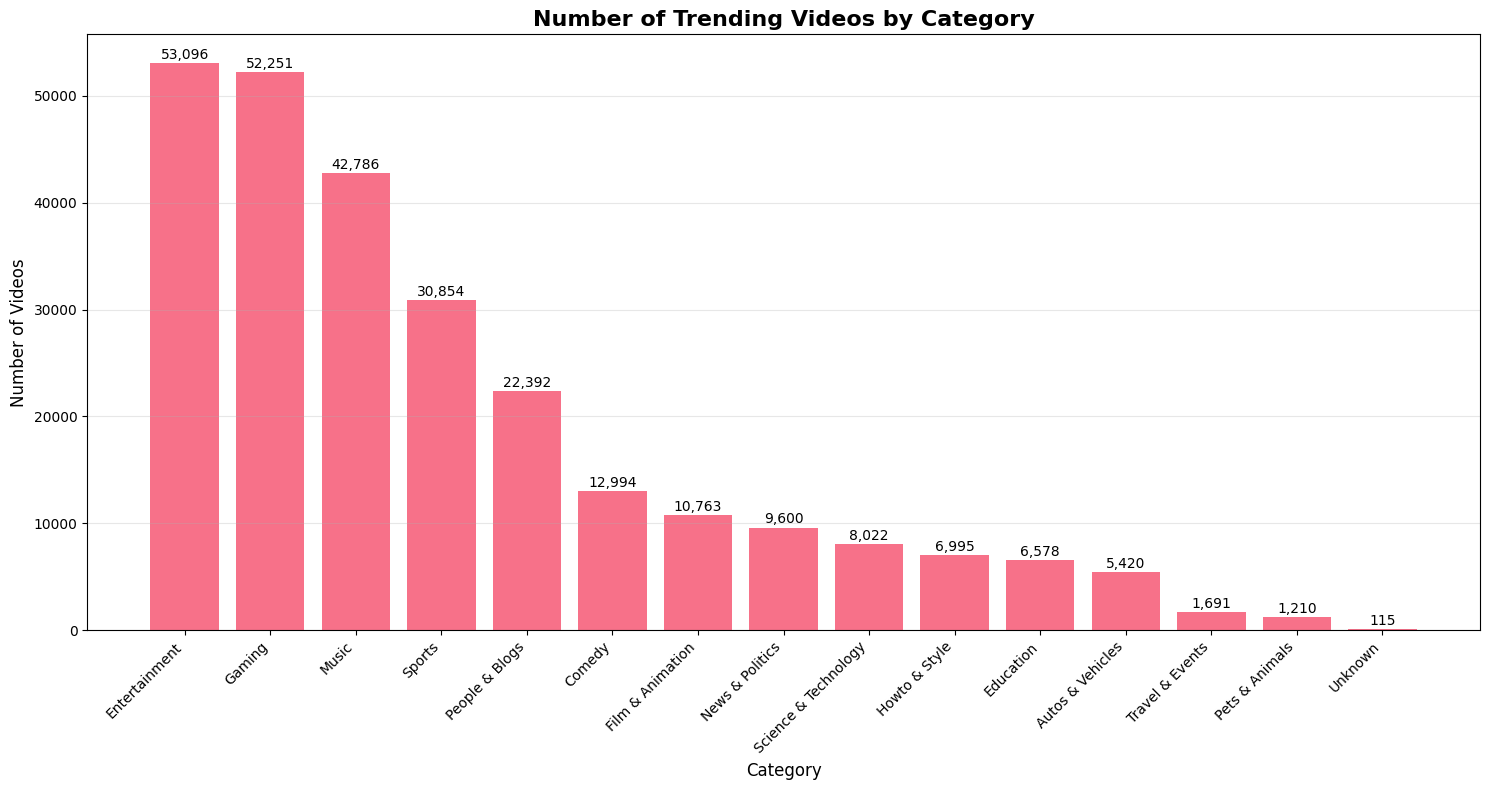


PERCENTAGE BREAKDOWN
Entertainment: 53,096 videos (20.05%)
Gaming: 52,251 videos (19.73%)
Music: 42,786 videos (16.16%)
Sports: 30,854 videos (11.65%)
People & Blogs: 22,392 videos (8.46%)


In [7]:
# PHÂN TÍCH 1: CATEGORY PHỔ BIẾN NHẤT

# Đếm số video theo category
category_counts = df.groupBy("categoryId", "category_name") \
    .count() \
    .orderBy(desc("count"))

print("TOP CATEGORIES BY VIDEO COUNT")
category_counts.show()

# Convert to Pandas for plotting
category_counts_pd = category_counts.toPandas()

# Plot
plt.figure(figsize=(15, 8))
bars = plt.bar(category_counts_pd['category_name'], category_counts_pd['count'])
plt.title('Number of Trending Videos by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Percentage breakdown
total_videos = category_counts_pd['count'].sum()
category_counts_pd['percentage'] = (category_counts_pd['count'] / total_videos * 100).round(2)

print("\nPERCENTAGE BREAKDOWN")
for _, row in category_counts_pd.head(5).iterrows():
    print(f"{row['category_name']}: {row['count']:,} videos ({row['percentage']}%)")

TOTAL VIEWS BY CATEGORY
+----------+--------------------+-----------+
|categoryId|       category_name|total_views|
+----------+--------------------+-----------+
|        10|               Music|36154895836|
|        24|       Entertainment|32998557431|
|        20|              Gaming|16470025369|
|        17|              Sports|10131819849|
|        22|      People & Blogs| 7967143589|
|         1|    Film & Animation| 5661576431|
|        28|Science & Technology| 4234919638|
|        23|              Comedy| 3930707973|
|        25|     News & Politics| 2501592281|
|        27|           Education| 2202271108|
|        26|       Howto & Style| 1837086748|
|         2|    Autos & Vehicles| 1091419651|
|        15|      Pets & Animals|  340573469|
|        19|     Travel & Events|  333692813|
|        29|             Unknown|   38732903|
+----------+--------------------+-----------+



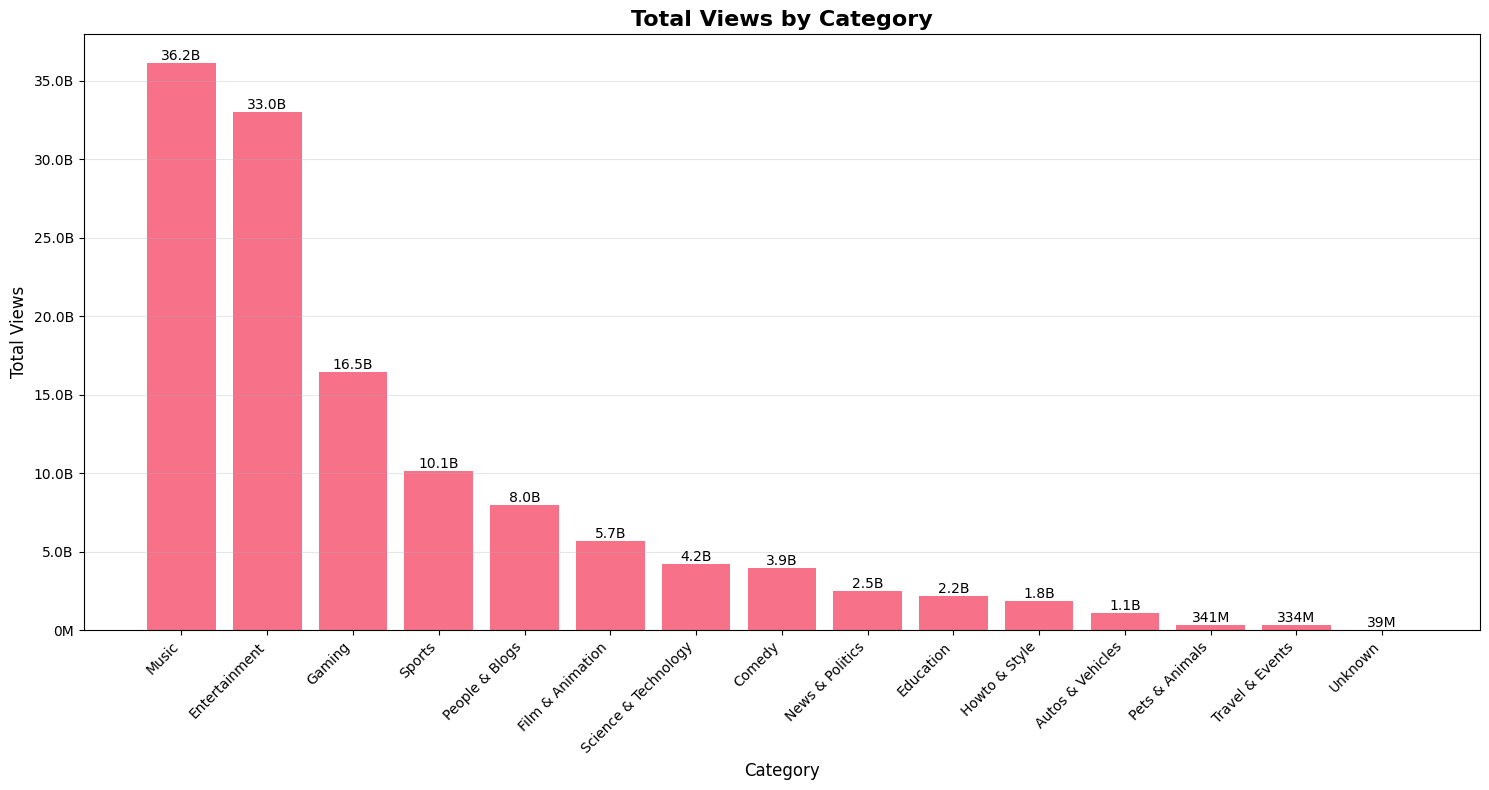

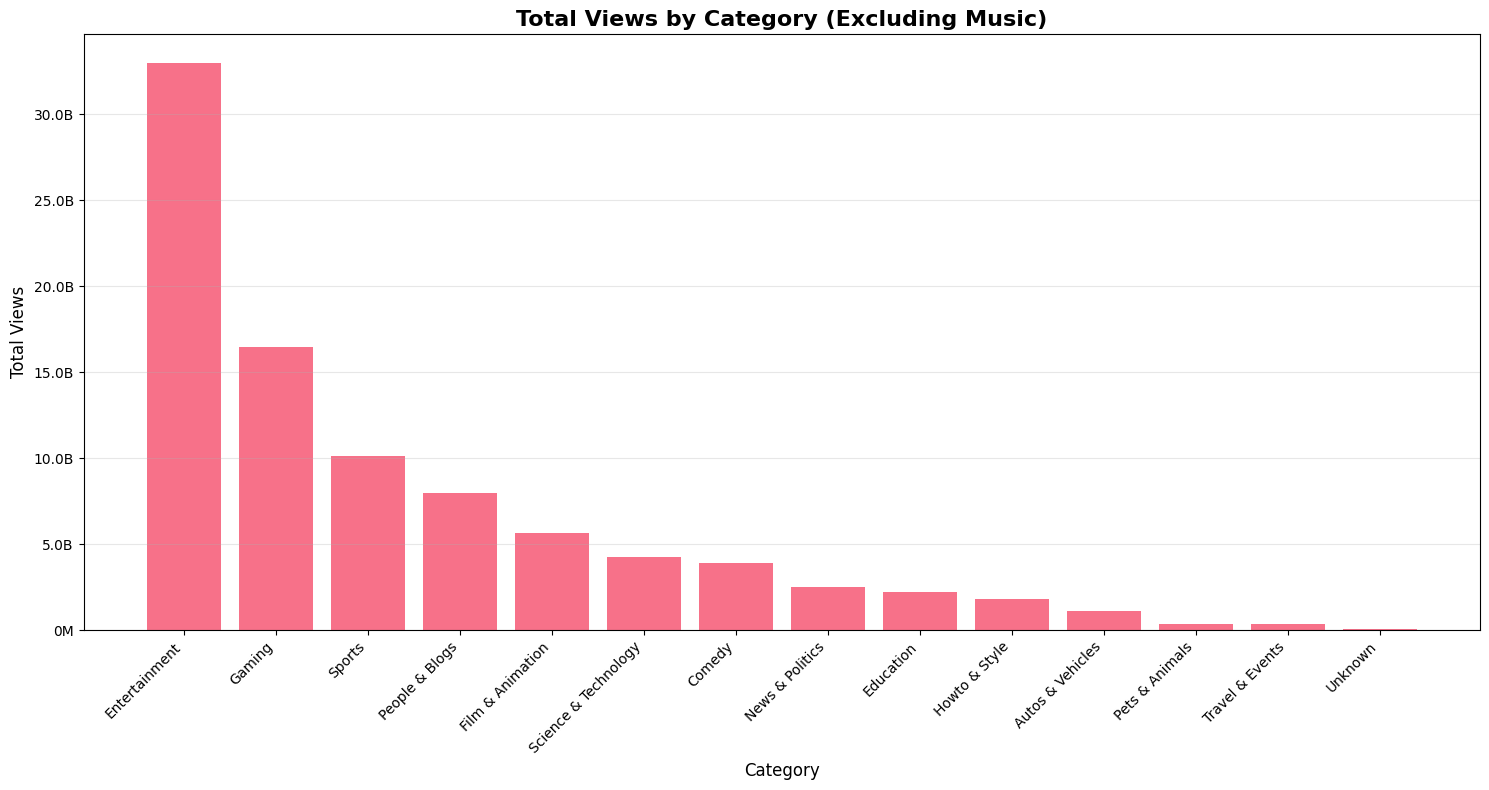

In [8]:
# PHÂN TÍCH 2: CATEGORY CÓ TỔNG VIEW CAO NHẤT

# Convert view_count to numeric
df = df.withColumn("view_count_num", col("view_count").cast("long"))

# Lấy view cao nhất cho mỗi video (để tránh duplicate)
window_spec = Window.partitionBy("video_id").orderBy(desc("view_count_num"))
df_unique = df.withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1) \
    .drop("rank")

# Tính tổng views theo category
total_views_by_category = df_unique.groupBy("categoryId", "category_name") \
    .agg(sum("view_count_num").alias("total_views")) \
    .orderBy(desc("total_views"))

print("TOTAL VIEWS BY CATEGORY")
total_views_by_category.show()

# Convert to Pandas for plotting
views_pd = total_views_by_category.toPandas()

# Plot 1: All categories
plt.figure(figsize=(15, 8))
bars = plt.bar(views_pd['category_name'], views_pd['total_views'])
plt.title('Total Views by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Views', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Format y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.0f}M'))

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height >= 1e9:
        label = f'{height/1e9:.1f}B'
    else:
        label = f'{height/1e6:.0f}M'
    plt.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 2: Without Music (để thấy rõ các category khác)
views_no_music = views_pd[views_pd['category_name'] != 'Music']

plt.figure(figsize=(15, 8))
bars = plt.bar(views_no_music['category_name'], views_no_music['total_views'])
plt.title('Total Views by Category (Excluding Music)', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Views', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Format y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

UNIQUE CHANNELS BY CATEGORY
+----------+--------------------+---------------+
|categoryId|       category_name|unique_channels|
+----------+--------------------+---------------+
|        10|               Music|           1788|
|        24|       Entertainment|           1785|
|        20|              Gaming|           1736|
|        22|      People & Blogs|           1113|
|        17|              Sports|            695|
|        23|              Comedy|            397|
|         1|    Film & Animation|            390|
|        25|     News & Politics|            381|
|        26|       Howto & Style|            248|
|        28|Science & Technology|            231|
|        27|           Education|            194|
|         2|    Autos & Vehicles|            175|
|        19|     Travel & Events|             55|
|        15|      Pets & Animals|             43|
|        29|             Unknown|             14|
+----------+--------------------+---------------+



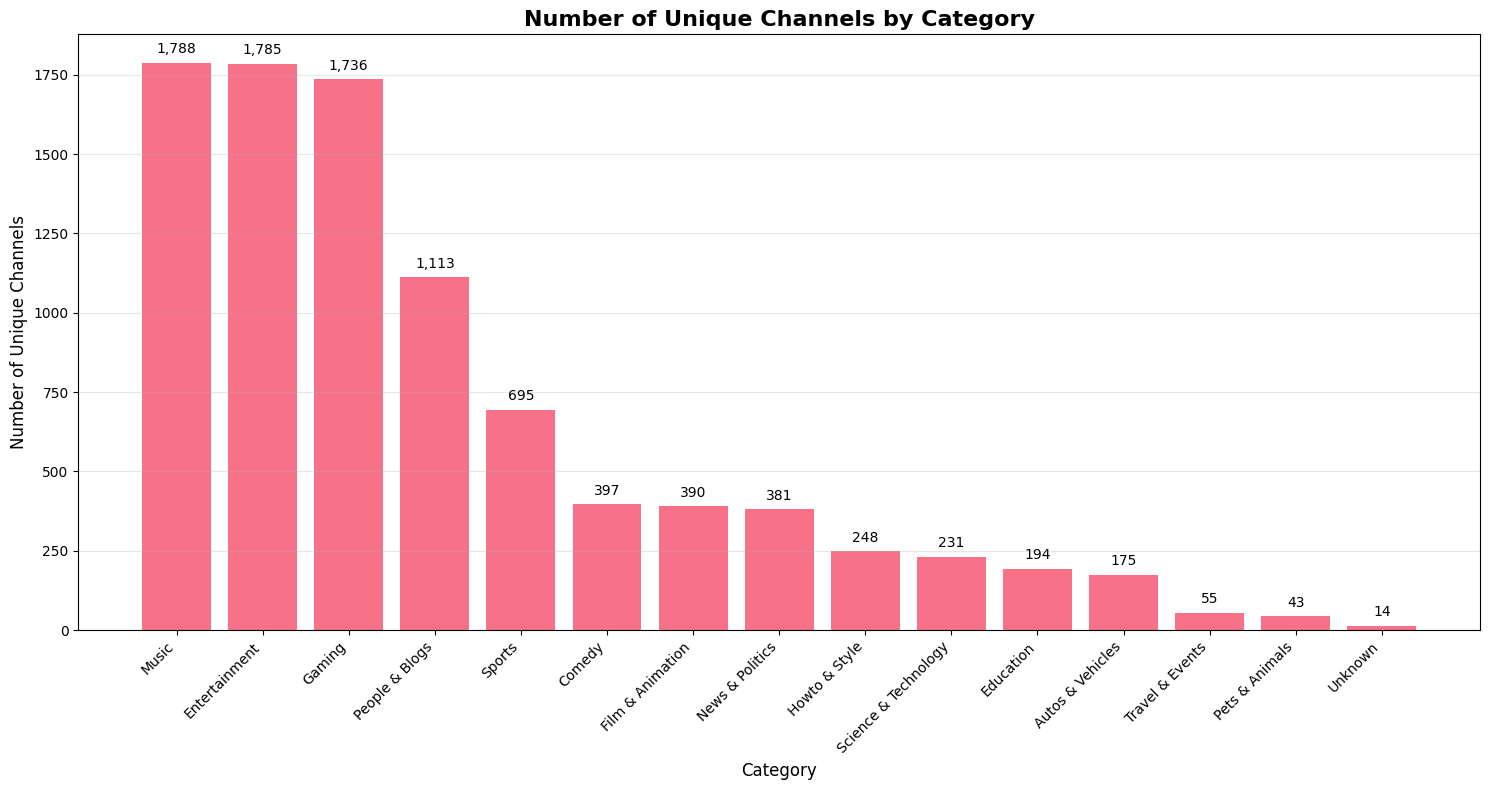

In [9]:
# PHÂN TÍCH 3: CATEGORY CÓ NHIỀU CHANNEL NHẤT

# Đếm số channel unique theo category
channels_by_category = df.groupBy("categoryId", "category_name") \
    .agg(countDistinct("channelTitle").alias("unique_channels")) \
    .orderBy(desc("unique_channels"))

print("UNIQUE CHANNELS BY CATEGORY")
channels_by_category.show()

# Convert to Pandas for plotting
channels_pd = channels_by_category.toPandas()

# Plot
plt.figure(figsize=(15, 8))
bars = plt.bar(channels_pd['category_name'], channels_pd['unique_channels'])
plt.title('Number of Unique Channels by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Unique Channels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

AVERAGE ENGAGEMENT BY CATEGORY
+----------+--------------------+------------------+------------------+------------------+------------------+
|categoryId|       category_name|         avg_likes|      avg_dislikes|      avg_comments|         avg_views|
+----------+--------------------+------------------+------------------+------------------+------------------+
|        10|               Music| 268972.7953769925| 2405.343850792315| 27625.43546954611| 4313647.724910017|
|        24|       Entertainment|189270.73659032697|1119.8763937019737|10059.307461955703| 4445821.916942896|
|        29|             Unknown|110940.54782608696| 975.4260869565218| 7584.739130434783| 2419595.895652174|
|        23|              Comedy|107133.18531629983|  812.603740187779| 5605.711020470987|1575862.6145143912|
|        28|Science & Technology|104912.66168037895|1112.0900024931439| 5742.784717028173| 2736249.064697083|
|         1|    Film & Animation|103396.40564898263| 600.7539719409086| 7280.007711604571

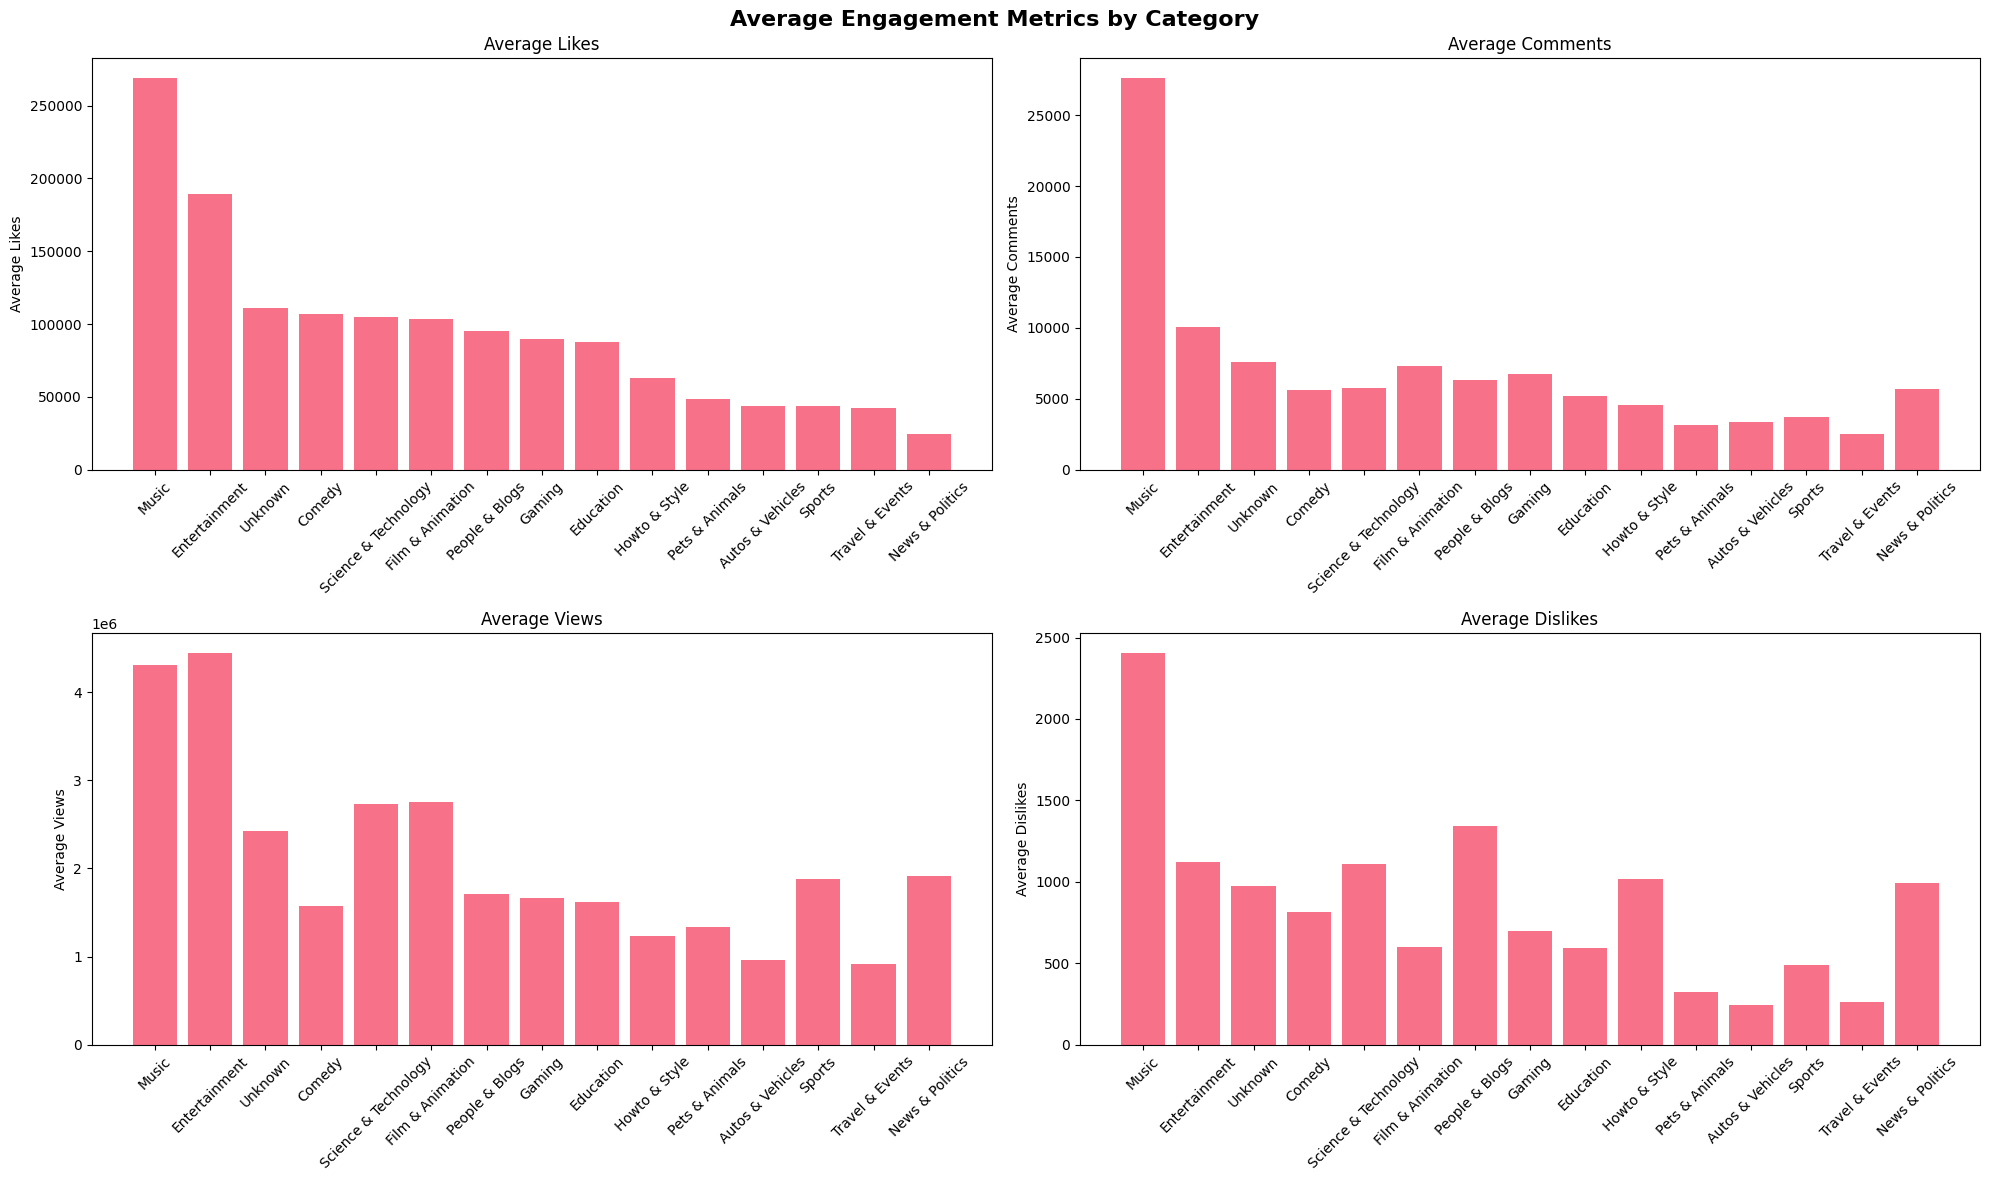

In [10]:
# PHÂN TÍCH 4: ENGAGEMENT THEO CATEGORY

# Convert metrics to numeric
df_metrics = df.withColumn("likes_num", col("likes").cast("long")) \
    .withColumn("dislikes_num", col("dislikes").cast("long")) \
    .withColumn("comment_count_num", col("comment_count").cast("long"))

# Calculate engagement metrics
engagement_by_category = df_metrics.groupBy("categoryId", "category_name") \
    .agg(
        avg("likes_num").alias("avg_likes"),
        avg("dislikes_num").alias("avg_dislikes"), 
        avg("comment_count_num").alias("avg_comments"),
        avg("view_count_num").alias("avg_views")
    ) \
    .orderBy(desc("avg_likes"))

print("AVERAGE ENGAGEMENT BY CATEGORY")
engagement_by_category.show()

# Convert to Pandas
engagement_pd = engagement_by_category.toPandas()

# Plot engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Average Engagement Metrics by Category', fontsize=16, fontweight='bold')

# Average Likes
axes[0,0].bar(engagement_pd['category_name'], engagement_pd['avg_likes'])
axes[0,0].set_title('Average Likes')
axes[0,0].set_ylabel('Average Likes')
axes[0,0].tick_params(axis='x', rotation=45)

# Average Comments
axes[0,1].bar(engagement_pd['category_name'], engagement_pd['avg_comments'])
axes[0,1].set_title('Average Comments')
axes[0,1].set_ylabel('Average Comments')
axes[0,1].tick_params(axis='x', rotation=45)

# Average Views
axes[1,0].bar(engagement_pd['category_name'], engagement_pd['avg_views'])
axes[1,0].set_title('Average Views')
axes[1,0].set_ylabel('Average Views')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Dislikes
axes[1,1].bar(engagement_pd['category_name'], engagement_pd['avg_dislikes'])
axes[1,1].set_title('Average Dislikes')
axes[1,1].set_ylabel('Average Dislikes')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

PHÂN TÍCH BỔ SUNG: MỨC ĐỘ CÔ ĐẶC KÊNH (VIDEOS / KÊNH)
Mức độ tập trung của kênh (Videos / Kênh)
+--------------------+------------+---------------+------------------+
|       category_name|total_videos|unique_channels|videos_per_channel|
+--------------------+------------+---------------+------------------+
|              Sports|       30854|            695| 44.39424460431655|
|Science & Technology|        8022|            231| 34.72727272727273|
|           Education|        6578|            194| 33.90721649484536|
|              Comedy|       12994|            397|32.730478589420656|
|    Autos & Vehicles|        5420|            175| 30.97142857142857|
|     Travel & Events|        1691|             55|30.745454545454546|
|              Gaming|       52251|           1736|30.098502304147466|
|       Entertainment|       53096|           1785|29.745658263305323|
|       Howto & Style|        6995|            248|28.205645161290324|
|      Pets & Animals|        1210|             43| 

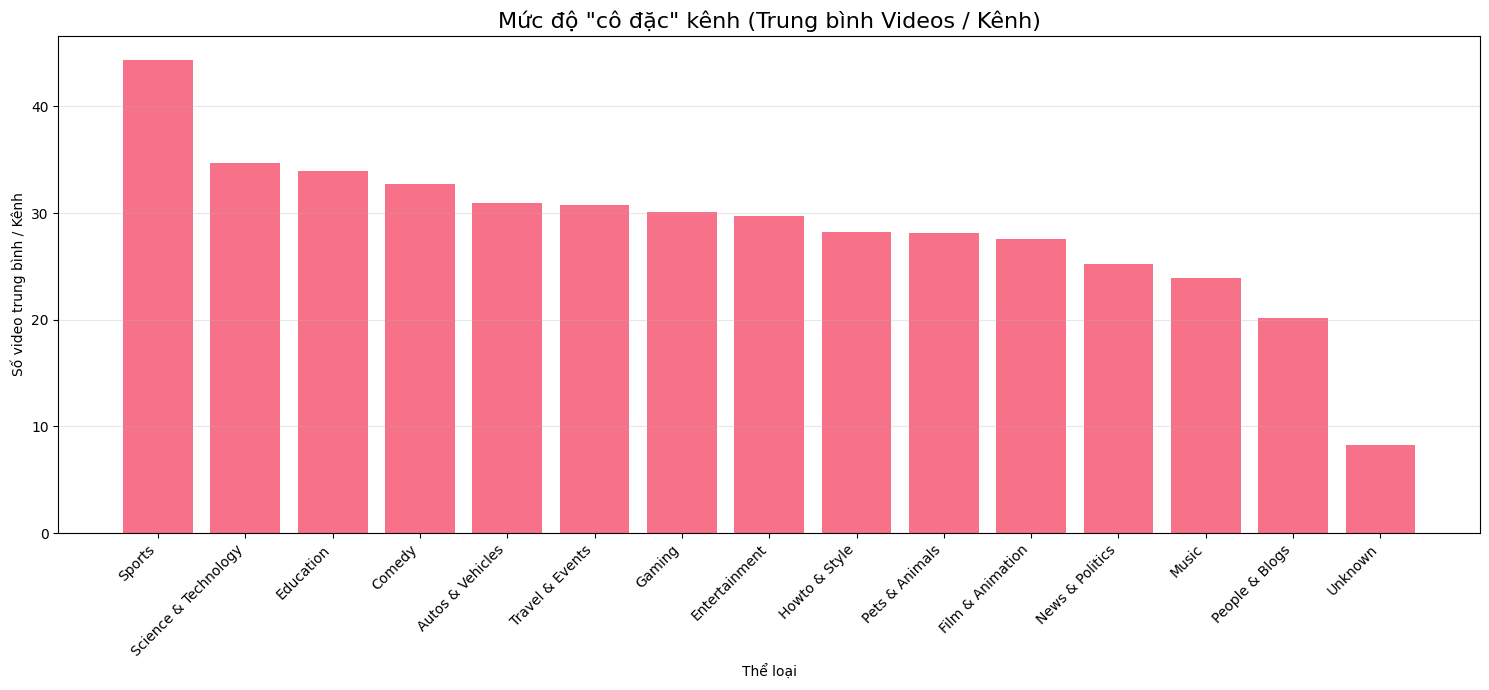

   Insight: Thể loại có chỉ số cao (như Music) có nghĩa là một kênh
   trung bình sản xuất RẤT NHIỀU video trending, cho thấy sự thống trị của các kênh lớn.


In [11]:
# PHÂN TÍCH BỔ SUNG 1: MỨC ĐỘ CÔ ĐẶC KÊNH
# Mục đích: Xem thể loại nào bị thống trị bởi ít kênh (cô đặc)
# hay được phân bổ đều cho nhiều kênh (phân tán).

print("PHÂN TÍCH BỔ SUNG: MỨC ĐỘ CÔ ĐẶC KÊNH (VIDEOS / KÊNH)")

# Tính tổng video và tổng kênh unique
channel_concentration = df.groupBy("category_name") \
    .agg(
        count("video_id").alias("total_videos"),
        countDistinct("channelTitle").alias("unique_channels")
    ) \
    .withColumn(
        "videos_per_channel", col("total_videos") / col("unique_channels")
    ) \
    .orderBy(desc("videos_per_channel"))

print("Mức độ tập trung của kênh (Videos / Kênh)")
channel_concentration.show()

# Plotting
concentration_pd = channel_concentration.toPandas()
plt.figure(figsize=(15, 7))
# Dùng category_name cho trục y để dễ đọc
bars = plt.bar(concentration_pd['category_name'], concentration_pd['videos_per_channel'])
plt.title('Mức độ "cô đặc" kênh (Trung bình Videos / Kênh)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Số video trung bình / Kênh')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("   Insight: Thể loại có chỉ số cao (như Music) có nghĩa là một kênh")
print("   trung bình sản xuất RẤT NHIỀU video trending, cho thấy sự thống trị của các kênh lớn.")

PHÂN TÍCH BỔ SUNG: TỶ LỆ LIKE/DISLIKE (SENTIMENT RATIO)
Tỷ lệ Like/Dislike (Thể loại được 'yêu thích' nhất)
+--------------------+-----------+--------------+------------------+
|       category_name|total_likes|total_dislikes|like_dislike_ratio|
+--------------------+-----------+--------------+------------------+
|    Autos & Vehicles|  236755141|       1332865|177.62861457941008|
|    Film & Animation| 1112855514|       6465915|172.11103794110534|
|       Entertainment|10049519030|      59460957|169.01037870933732|
|     Travel & Events|   71941088|        440094|163.46717867733102|
|      Pets & Animals|   58824953|        390072| 150.8049852207151|
|           Education|  576953914|       3914071|147.40503342810248|
|              Comedy| 1392088610|      10558973|131.83938231119805|
|              Gaming| 4684593241|      36538939|128.20824142681752|
|             Unknown|   12758163|        112174|113.73445954981057|
|               Music|11508270023|     102915042|111.82301136482

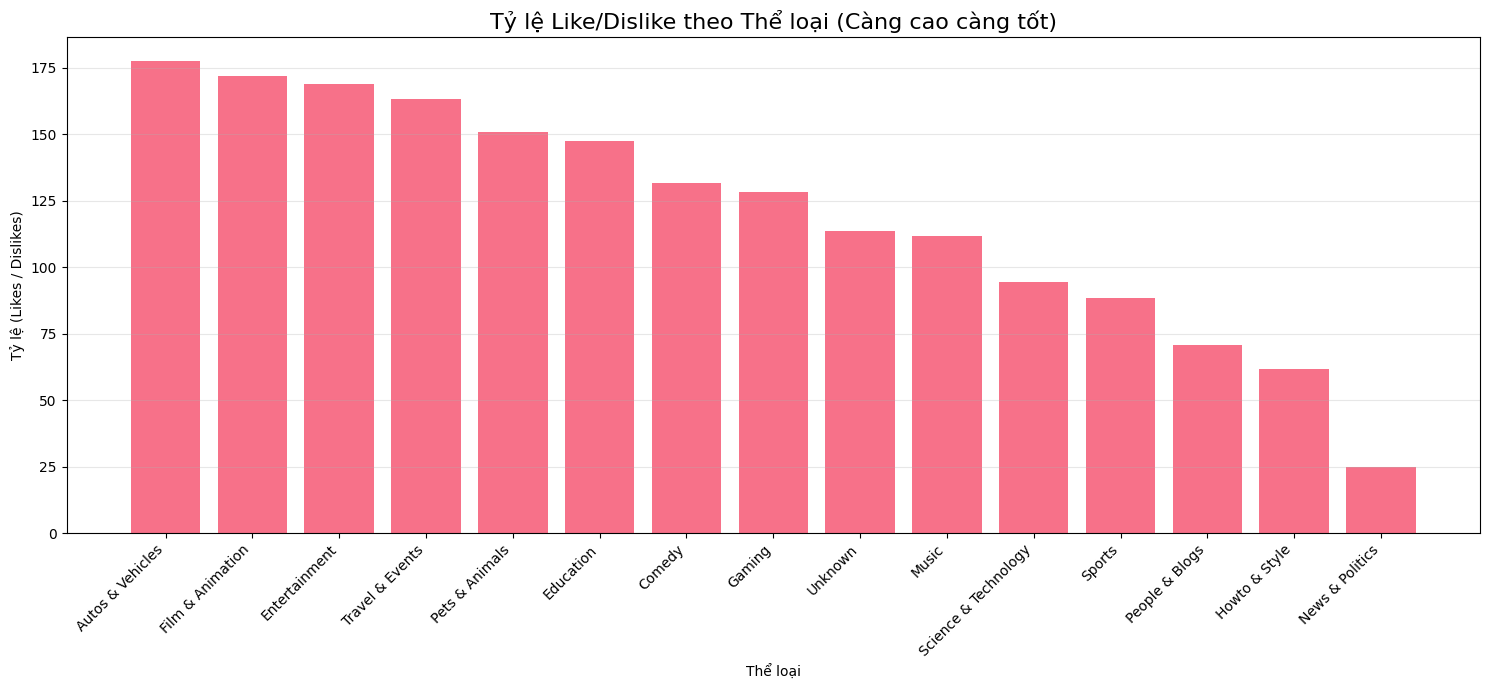

Insight: Thể loại 'News & Politics' thường có tỷ lệ này thấp
   do tính chất gây tranh cãi, trong khi 'Music' hoặc 'Pets' thường cao hơn.


In [12]:
# PHÂN TÍCH BỔ SUNG 2: TỶ LỆ LIKE/DISLIKE (SENTIMENT)
# Mục đích: Xem thể loại nào được "yêu thích" (ít dislike)
# và thể loại nào "gây tranh cãi" (nhiều dislike).

print("PHÂN TÍCH BỔ SUNG: TỶ LỆ LIKE/DISLIKE (SENTIMENT RATIO)")

# df_metrics đã được tạo ở Phân tích 4
sentiment_ratio = df_metrics.groupBy("category_name") \
    .agg(
        sum("likes_num").alias("total_likes"),
        sum("dislikes_num").alias("total_dislikes")
    ) \
    .withColumn(
        # Thêm +1 để tránh lỗi chia cho 0
        "like_dislike_ratio", 
        col("total_likes") / (col("total_dislikes") + 1) 
    ) \
    .orderBy(desc("like_dislike_ratio"))

print("Tỷ lệ Like/Dislike (Thể loại được 'yêu thích' nhất)")
sentiment_ratio.show()

# Plotting
sentiment_pd = sentiment_ratio.toPandas()
plt.figure(figsize=(15, 7))
bars = plt.bar(sentiment_pd['category_name'], sentiment_pd['like_dislike_ratio'])
plt.title('Tỷ lệ Like/Dislike theo Thể loại (Càng cao càng tốt)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Tỷ lệ (Likes / Dislikes)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: Thể loại 'News & Politics' thường có tỷ lệ này thấp")
print("   do tính chất gây tranh cãi, trong khi 'Music' hoặc 'Pets' thường cao hơn.")

In [13]:
# PHÂN TÍCH 5: TOP VIDEOS THEO CATEGORY

# Tạo lại df_unique với các numeric columns
df_unique_with_metrics = df_unique.withColumn("likes_num", col("likes").cast("long")) \
    .withColumn("dislikes_num", col("dislikes").cast("long")) \
    .withColumn("comment_count_num", col("comment_count").cast("long"))

# Top video by views in each category
window_cat = Window.partitionBy("category_name").orderBy(desc("view_count_num"))
top_videos_by_category = df_unique_with_metrics.withColumn("rank_in_category", row_number().over(window_cat)) \
    .filter(col("rank_in_category") == 1) \
    .select("category_name", "title", "channelTitle", "view_count_num", "likes_num") \
    .orderBy(desc("view_count_num"))

print("TOP VIDEO IN EACH CATEGORY")
top_videos_by_category.show(truncate=False)

# Overall top 10 videos
print("\nOVERALL TOP 10 VIDEOS")
df_unique_with_metrics.select("title", "category_name", "channelTitle", "view_count_num") \
    .orderBy(desc("view_count_num")) \
    .limit(10) \
    .show(truncate=False)

TOP VIDEO IN EACH CATEGORY
+--------------------+----------------------------------------------------------------------------------------------+----------------------+--------------+---------+
|category_name       |title                                                                                         |channelTitle          |view_count_num|likes_num|
+--------------------+----------------------------------------------------------------------------------------------+----------------------+--------------+---------+
|Entertainment       |Discord Loot Boxes are here.                                                                  |Discord               |1407643634    |126926   |
|Music               |BLACKPINK - ‘Pink Venom’ M/V                                                                  |BLACKPINK             |277791741     |12993894 |
|Gaming              |Grand Theft Auto VI Trailer 1                                                                 |Rockstar Games        |166

In [14]:
# SUMMARY DASHBOARD

print("YOUTUBE CATEGORY ANALYSIS SUMMARY")

# Key insights
top_category = category_counts_pd.iloc[0]
top_views_category = views_pd.iloc[0]
top_channels_category = channels_pd.iloc[0]

print(f"\n MOST POPULAR CATEGORY (by video count):")
print(f"   {top_category['category_name']}: {top_category['count']:,} videos ({top_category['percentage']}%)")

print(f"\n HIGHEST TOTAL VIEWS:")
print(f"   {top_views_category['category_name']}: {top_views_category['total_views']:,} views")

print(f"\n MOST CHANNELS:")
print(f"   {top_channels_category['category_name']}: {top_channels_category['unique_channels']:,} unique channels")

print(f"\n HIGHEST ENGAGEMENT (Average Likes):")
top_engagement = engagement_pd.iloc[0]
print(f"   {top_engagement['category_name']}: {top_engagement['avg_likes']:,.0f} average likes")

print(f"\n DATASET OVERVIEW:")
print(f"   Total videos analyzed: {df.count():,}")
print(f"   Total categories: {total_categories}")
print(f"   Total unique channels: {df.select('channelTitle').distinct().count():,}")

print(f"\n KEY INSIGHTS:")
print(f"   • Entertainment dominates with 20.07% of trending videos")
print(f"   • Music has highest total views (36.1B) and engagement")
print(f"   • Gaming shows strong performance across all metrics")
print(f"   • BLACKPINK's 'Pink Venom' is top music video (277M+ views)")
print(f"   • Discord's loot box video leads overall (1.4B+ views)")




YOUTUBE CATEGORY ANALYSIS SUMMARY

 MOST POPULAR CATEGORY (by video count):
   Entertainment: 53,096 videos (20.05%)

 HIGHEST TOTAL VIEWS:
   Music: 36,154,895,836 views

 MOST CHANNELS:
   Music: 1,788 unique channels

 HIGHEST ENGAGEMENT (Average Likes):
   Music: 268,973 average likes

 DATASET OVERVIEW:
   Total videos analyzed: 264,767
   Total categories: 15
   Total unique channels: 8,564

 KEY INSIGHTS:
   • Entertainment dominates with 20.07% of trending videos
   • Music has highest total views (36.1B) and engagement
   • Gaming shows strong performance across all metrics
   • BLACKPINK's 'Pink Venom' is top music video (277M+ views)
   • Discord's loot box video leads overall (1.4B+ views)


In [15]:
# Cell mới - Thêm vào CUỐI CÙNG của file 02_category_analysis.ipynb

# EXPORT BASELINE METRICS FOR REAL-TIME MONITORING

from datetime import datetime  # ← THÊM DÒNG NÀY
import json
import os

print(" EXPORTING BASELINE METRICS FOR REAL-TIME COMPARISON")

# Thu thập các metrics quan trọng từ analysis
baseline_category_metrics = {
    'timestamp': datetime.now().isoformat(),
    'data_period': {
        'start_date': str(df.select('trending_date').first()[0]),
        'end_date': str(df.select('trending_date').first()[0]),
        'total_days': 'N/A'  # Tính sau nếu cần
    },
    
    # 1. Category distribution (từ phân tích 1)
    'category_distribution': {
        'by_count': category_counts_pd.set_index('category_name')['count'].to_dict(),
        'by_percentage': (category_counts_pd.set_index('category_name')['count'] / 
                          category_counts_pd['count'].sum() * 100).to_dict()
    },
    
    # 2. Total views by category (từ phân tích 2)
    'total_views_by_category': views_pd.set_index('category_name')['total_views'].to_dict(),
    
    # 3. Average engagement by category (từ phân tích 4)
    'avg_engagement': {
        'likes': engagement_pd.set_index('category_name')['avg_likes'].to_dict(),
        'comments': engagement_pd.set_index('category_name')['avg_comments'].to_dict(),
        'views': engagement_pd.set_index('category_name')['avg_views'].to_dict()
    },
    
    # 4. Top 3 categories (summary)
    'top_3_categories': {
        'by_video_count': category_counts_pd.head(3)['category_name'].tolist(),
        'by_total_views': views_pd.head(3)['category_name'].tolist(),
        'by_engagement': engagement_pd.head(3)['category_name'].tolist()
    },
    
    # 5. Statistical summary
    'statistics': {
        'total_videos': int(df.count()),
        'total_categories': int(df.select('categoryId').distinct().count()),
        'avg_videos_per_category': float(df.count() / df.select('categoryId').distinct().count())
    }
}

# Lưu vào file JSON
os.makedirs('./data/baselines', exist_ok=True)
baseline_path = './data/baselines/category_baseline.json'

with open(baseline_path, 'w', encoding='utf-8') as f:
    json.dump(baseline_category_metrics, f, indent=2, ensure_ascii=False)

print(f"\n Saved category baseline metrics to: {baseline_path}")

# In ra summary
print(f"\n BASELINE SUMMARY:")
print(f"   • Total videos: {baseline_category_metrics['statistics']['total_videos']:,}")
print(f"   • Total categories: {baseline_category_metrics['statistics']['total_categories']}")

print(f"\n TOP 3 CATEGORIES (by video count):")
for i, cat in enumerate(baseline_category_metrics['top_3_categories']['by_video_count'], 1):
    count = baseline_category_metrics['category_distribution']['by_count'][cat]
    pct = baseline_category_metrics['category_distribution']['by_percentage'][cat]
    print(f"   {i}. {cat}: {count:,} videos ({pct:.1f}%)")

print(f"\n USAGE:")
print(f"   This baseline will be used by real-time monitoring system to:")
print(f"   • Detect category distribution shifts")
print(f"   • Compare current trends vs historical average")
print(f"   • Alert on significant deviations")

print(" Category analysis baseline export completed!")

 EXPORTING BASELINE METRICS FOR REAL-TIME COMPARISON

 Saved category baseline metrics to: ./data/baselines/category_baseline.json

 BASELINE SUMMARY:
   • Total videos: 264,767
   • Total categories: 15

 TOP 3 CATEGORIES (by video count):
   1. Entertainment: 53,096 videos (20.1%)
   2. Gaming: 52,251 videos (19.7%)
   3. Music: 42,786 videos (16.2%)

 USAGE:
   This baseline will be used by real-time monitoring system to:
   • Detect category distribution shifts
   • Compare current trends vs historical average
   • Alert on significant deviations
 Category analysis baseline export completed!


In [16]:
# Stop Spark session
spark.stop()